
## Web Service Classification using BERT (RoBERTa)

## 1.  Load Python Modules

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
)
import warnings
import torch
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
%matplotlib inline

sns.set(style="whitegrid")
os.makedirs("charts", exist_ok=True)
os.makedirs("results", exist_ok=True)
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior (optional: slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

cuda


## 2. Generate Report in CSV

In [2]:
def generate_report_csv(report_dict, confusion_mat, class_labels, class_names, output_file="BERT-Report.csv"):
    df = pd.DataFrame(report_dict).transpose()

    # Filter only the class rows (not avg/macro)
    filtered_labels = [str(class_names[i]) for i in class_labels]
    df = df.loc[filtered_labels].copy()

    # Compute per-class accuracy
    row_sums = confusion_mat.sum(axis=1)
    diagonal = np.diag(confusion_mat)
    per_class_accuracy = (diagonal / row_sums).round(2)

    df['accuracy'] = per_class_accuracy
    if 'support' in df.columns:
        df = df.drop(columns=['support'])

    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Category'}, inplace=True)

    output_path = f"results/{output_file}"
    df.to_csv(output_path, index=False)
    print(f"Classification report saved to: {output_path}")

## 3. Model -Helper-functions

In [3]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average='weighted', zero_division=0),
        "recall": recall_score(labels, preds, average='weighted', zero_division=0),
        "f1": f1_score(labels, preds, average='weighted', zero_division=0)
    }

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

def plot_confusion_and_report(y_true, y_pred, class_names, n):
    cm = confusion_matrix(y_true, y_pred)
    figsize = (18, 18) if n >= 40 else (8, 8)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - Top {n} Categories")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"charts/BERT_confusion_matrix_top_{n}.png")
    plt.show()

    print(f"classification_report for {n} Web Serivce Categories")
    # Convert class_names to list of strings
    class_names_str = [str(name) for name in class_names]
    
    # Get sorted list of unique label integers
    labels = sorted(np.unique(y_true))

    # classification_report for print
    print(classification_report(y_true, y_pred, target_names=class_names_str, zero_division=0))

    # classification_report for dictionary
    report_dict = classification_report(y_true, y_pred, target_names=class_names_str, output_dict=True, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Save to CSV
    generate_report_csv(report_dict, cm, class_labels=labels, class_names=class_names_str, output_file=f"BERT-Report-Top-{n}.csv")

    return report_dict

def plot_metrics(bert_results):
    categories = list(bert_results.keys())
    accuracies = [bert_results[n]['accuracy'] for n in categories]
    precisions = [bert_results[n]['precision'] for n in categories]
    recalls = [bert_results[n]['recall'] for n in categories]
    f1_scores = [bert_results[n]['f1_score'] for n in categories]

    def plot_metric(x, y, ylabel, title, color='blue'):
        plt.figure(figsize=(8, 5))
        plt.plot(x, y, marker='o', linestyle='-', color=color)
        plt.title(title)
        plt.xlabel('Number of Web Serivce Categories')
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.xticks(x)
        plt.tight_layout()
        plt.savefig(f"charts/{title}.png")
        plt.show()

    plot_metric(categories, accuracies, 'Accuracy', 'BERT Model Performace Accuracy', color='green')
    plot_metric(categories, precisions, 'Precision', 'BERT Model Performace Precision', color='orange')
    plot_metric(categories, recalls, 'Recall', 'BERT Model Performace Recall', color='purple')
    plot_metric(categories, f1_scores, 'F1 Score', 'BERT Model Performace F1 Score', color='red')


## 4. Pre Processing Text

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    return " ".join(lemmatized_tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 5. Train and Evaluate

In [5]:
def train_and_evaluate(n):
    df = pd.read_csv(f"../data/Balanced_Top_{n}_Web_Services.csv").dropna()
    df = df[['Service Description', 'Grouped Category']].rename(columns={'Service Description': 'text', 'Grouped Category': 'label'})


    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
    num_labels = df['label'].nunique()
    class_names = label_encoder.classes_

    dataset = Dataset.from_pandas(df.reset_index(drop=True))
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(["text"])

    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
    training_args = TrainingArguments(
        output_dir=f"./results_top_{n}",
        num_train_epochs=5,
        eval_strategy="epoch",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs_top_{n}",
        logging_strategy="steps",
        logging_steps=100,
        seed=42,  
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['test'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    preds = trainer.predict(tokenized_dataset['test'])
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    metrics = compute_metrics((preds.predictions, y_true))

    report = plot_confusion_and_report(y_true, y_pred, class_names, n)
    

    return {
        "accuracy": metrics["accuracy"],
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1_score": metrics["f1"]
    }


## 6. Run the Model


 Processing Top 45 Web Service Categories


Map:   0%|          | 0/7195 [00:00<?, ? examples/s]

Map:   0%|          | 0/1799 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.105200,0.956657,0.763758,0.759012,0.763758,0.750459
2,0.629300,0.878856,0.795442,0.801692,0.795442,0.786524
3,0.420000,0.858592,0.829350,0.830754,0.829350,0.824900
4,0.168300,0.871498,0.852696,0.857280,0.852696,0.852360
5,0.071500,0.877645,0.858255,0.860567,0.858255,0.857408


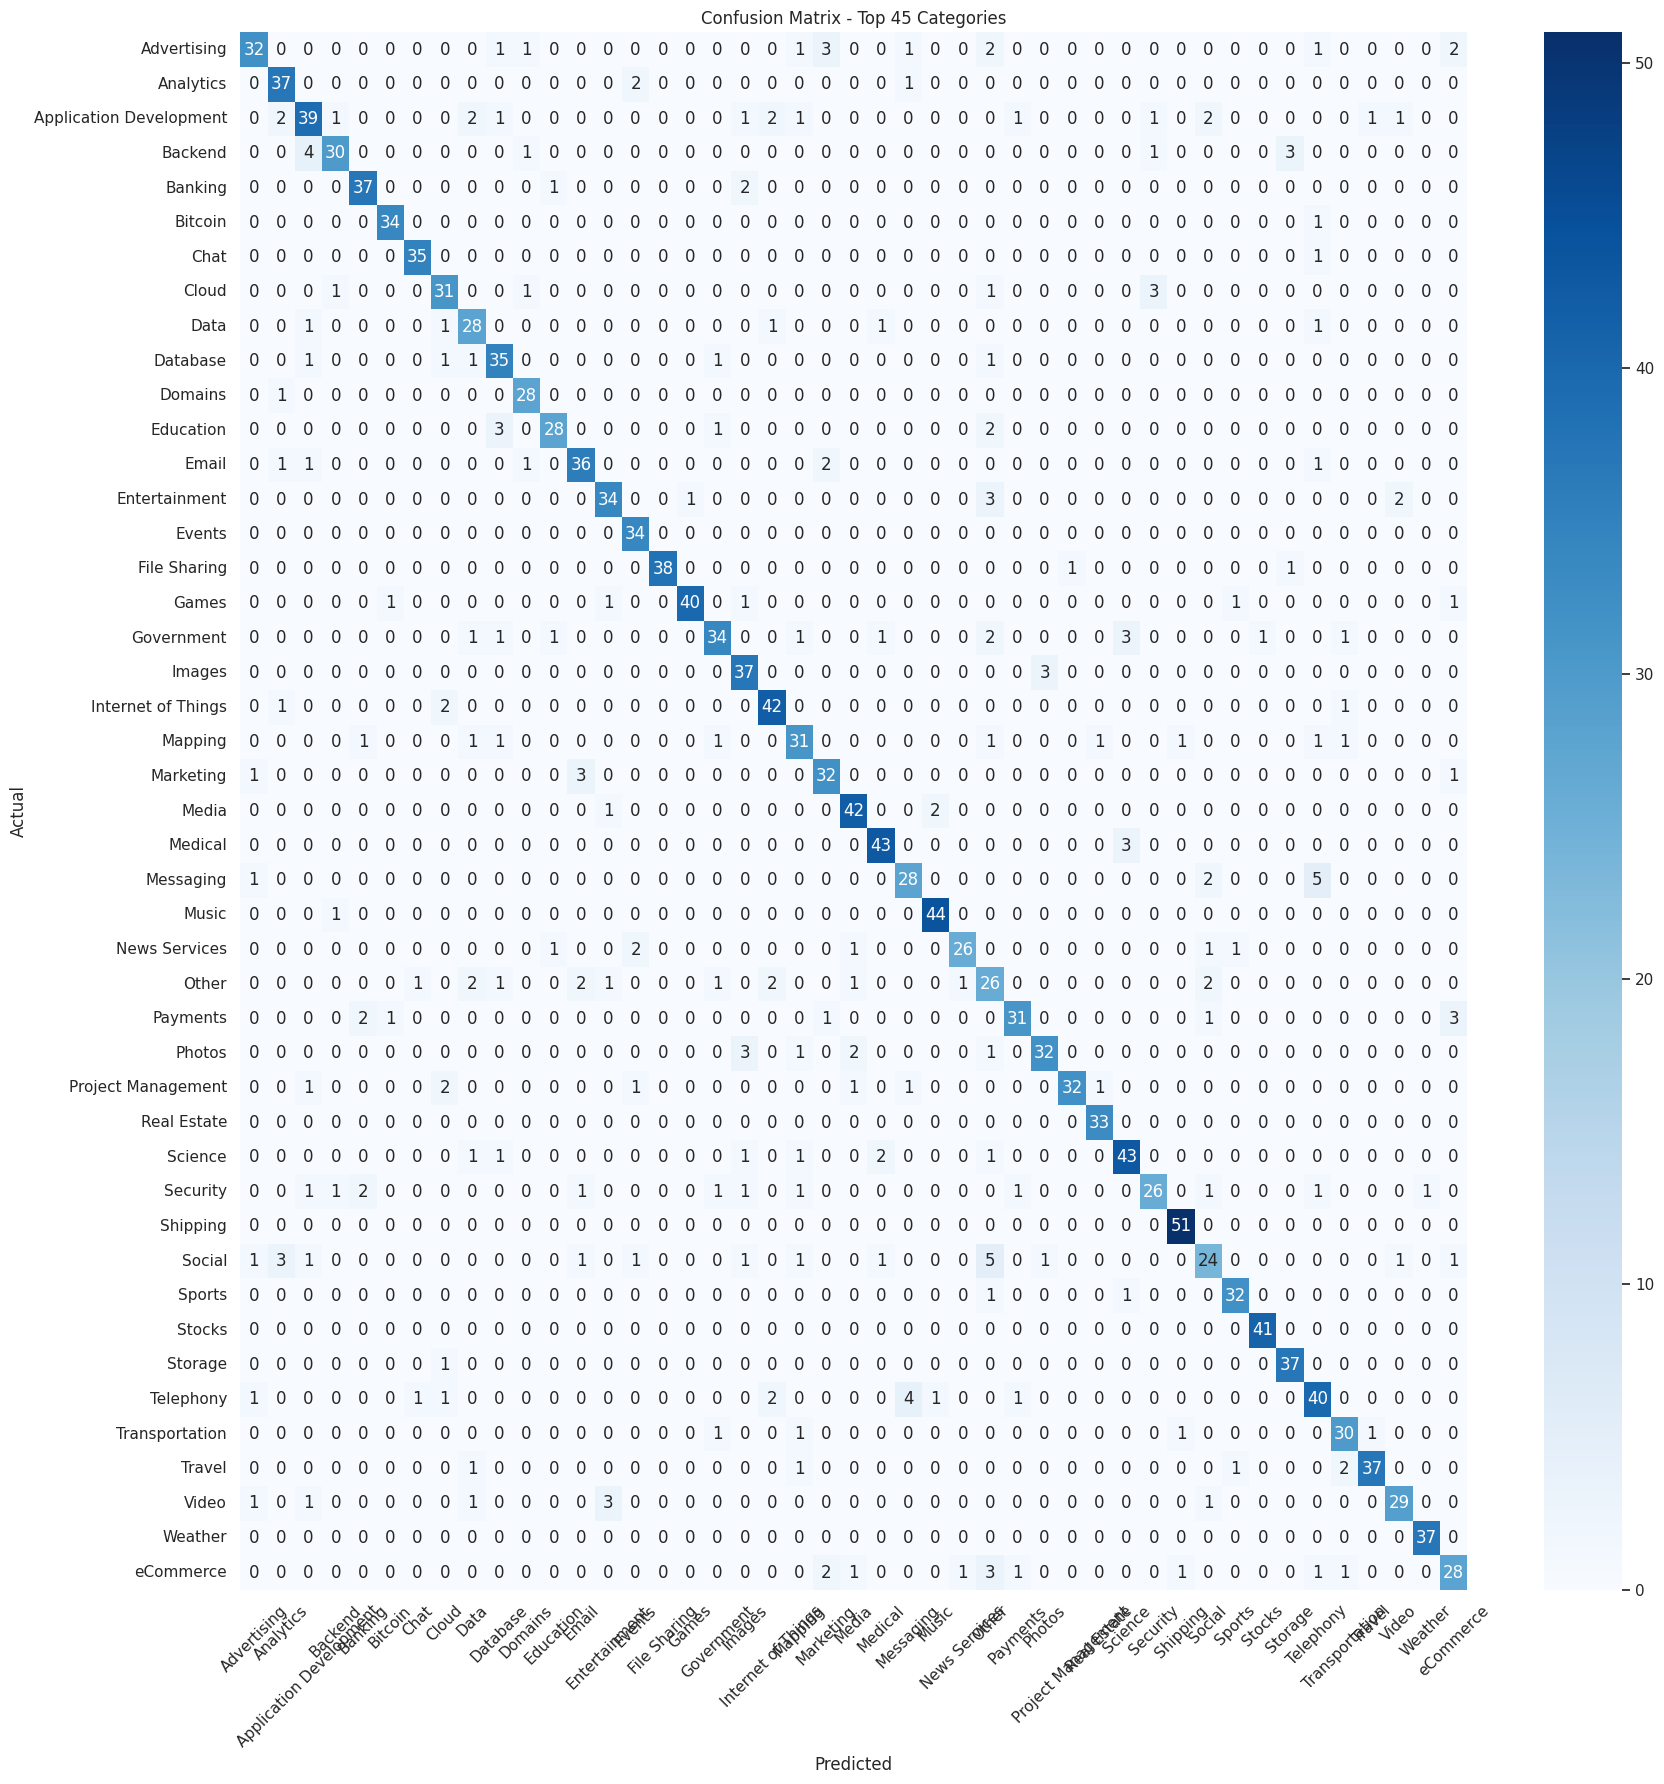

classification_report for 45 Web Serivce Categories
                         precision    recall  f1-score   support

            Advertising       0.86      0.73      0.79        44
              Analytics       0.82      0.93      0.87        40
Application Development       0.78      0.71      0.74        55
                Backend       0.88      0.77      0.82        39
                Banking       0.88      0.93      0.90        40
                Bitcoin       0.94      0.97      0.96        35
                   Chat       0.95      0.97      0.96        36
                  Cloud       0.79      0.84      0.82        37
                   Data       0.74      0.85      0.79        33
               Database       0.80      0.88      0.83        40
                Domains       0.88      0.97      0.92        29
              Education       0.90      0.82      0.86        34
                  Email       0.84      0.86      0.85        42
          Entertainment       0.85   

In [6]:
# Run and collect results
bert_results = []
for n in [45]:
    print(f"\n Processing Top {n} Web Service Categories")
    bert_results.append(train_and_evaluate(n))
bert_results[0]['model']='BERT'
# Save results
with open("results/bert_results.pkl", "wb") as f:
    pickle.dump(bert_results, f)

## 7. Performance and Plots

[{'accuracy': 0.858254585881045, 'precision': 0.8605665403978022, 'recall': 0.858254585881045, 'f1_score': 0.8574081279687222}]


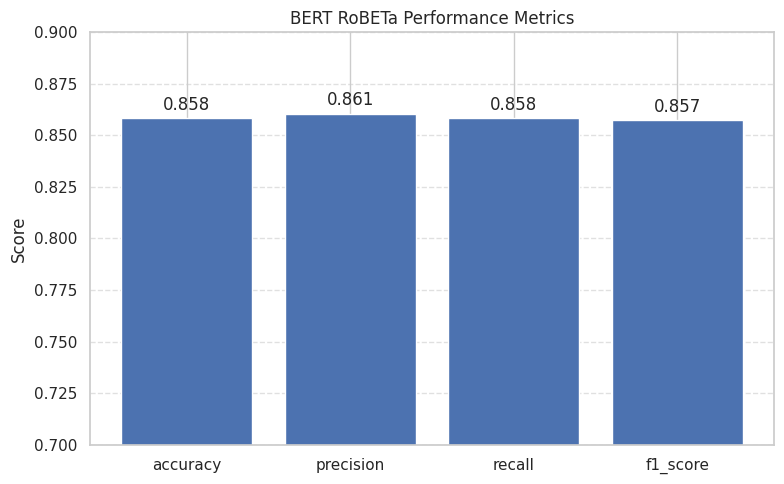

In [7]:
# Plot metrics
print(bert_results)
import matplotlib.pyplot as plt

# Plot settings
for metric_dict in bert_results:
    #model_name = metric_dict['model']
    metrics = {k: v for k, v in metric_dict.items() if k != 'model'}

    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values())
    
    # Labels and title
    plt.ylabel('Score')
    plt.ylim(0.7, 0.9)  # Adjust range as needed
    plt.title(f'BERT RoBETa Performance Metrics')

    # Annotate bar values
    for key, value in metrics.items():
        plt.text(key, value + 0.002, f"{value:.3f}", ha='center', va='bottom')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()